# Redes Neuronais Convolucionais em Classificação de Aves

### Trabalho Prático 1 - Computação Natural
Realizado por: Constança Elias - PG42820


---



Primeiro vamos começar por fazer importar o *dataset* para o disco do Colab.
Para isso fizémos upload do *dataset* zipado para o *drive* e aqui começamos por descomprimir a pasta e importá-la  para "*content*". 

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/TOUCHAN/080.jpg  
  inflating: /content/train/TOUCHAN/081.jpg  
  inflating: /content/train/TOUCHAN/082.jpg  
  inflating: /content/train/TOUCHAN/083.jpg  
  inflating: /content/train/TOUCHAN/084.jpg  
  inflating: /content/train/TOUCHAN/085.jpg  
  inflating: /content/train/TOUCHAN/086.jpg  
  inflating: /content/train/TOUCHAN/087.jpg  
  inflating: /content/train/TOUCHAN/088.jpg  
  inflating: /content/train/TOUCHAN/089.jpg  
  inflating: /content/train/TOUCHAN/090.jpg  
  inflating: /content/train/TOUCHAN/091.jpg  
  inflating: /content/train/TOUCHAN/092.jpg  
  inflating: /content/train/TOUCHAN/093.jpg  
  inflating: /content/train/TOUCHAN/094.jpg  
  inflating: /content/train/TOUCHAN/095.jpg  
  inflating: /content/train/TOUCHAN/096.jpg  
  inflating: /content/train/TOUCHAN/097.jpg  
  inflating: /content/train/TOUCHAN/098.jpg  
  inflating: /content/train/TOUCHAN/099.jpg  
  inflating: /content/train/T

Vamos fazer o *import* das bibliotecas necessárias.

In [3]:
# import the needed packages
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import choice
from random import uniform
from numpy.random import randint
from statistics import mean

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

In [5]:
#train, validation and test directories

training_dir = '/content/train'
validation_dir = '/content/valid'
test_dir = '/content/test'

## Análise do Dataset

Vamos começar por importar os datasets de treino e validação.

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

def generate_datasets(bs, train_datag):
  train_generator = train_datag.flow_from_directory(
      training_dir,  
      target_size = (224,224), 
      color_mode = 'rgb',
      class_mode = 'sparse',
      batch_size = bs)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size = (224,224),
      color_mode = 'rgb',
      class_mode = 'sparse',
      batch_size = bs)

  test_generator = validation_datagen.flow_from_directory(
      test_dir, 
      target_size = (224,224),
      color_mode = 'rgb',
      class_mode = 'sparse',
      batch_size = bs)
  
  return train_generator, validation_generator, test_generator

Vamos agora analisar o dataset de treino.

In [7]:
train_generator, validation_generator, test_generator = generate_datasets(16, train_datagen)


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [8]:
#map indexes in classes names
class_mapping = {v:k for k,v in train_generator.class_indices.items()}


Vamos definir uma função para apresentar algumas imagens do dataset numa grelha para melhor visualização.

In [9]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

#function from: https://expoundai.wordpress.com/2019/04/24/image-data-generators-in-keras/
def show_grid(image_list, nrows, ncols, label_list = None, show_labels = False, savename = None, figsize = (10,10), showaxis = 'off'):

    if type(image_list) is not list:
        if(image_list.shape[-1] == 1):
            image_list = [image_list[i, :, :, 0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1] == 3):
            image_list = [image_list[i, :, :, :] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize, frameon = False)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols = (nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad = 0.3,  # pad between axes in inch.
                     share_all = True,
                     )
    
    for i in range(nrows * ncols):
        ax = grid[i]
        ax.imshow(image_list[i], cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y[i]])
    if savename != None:
        plt.savefig(savename, bbox_inches = 'tight')

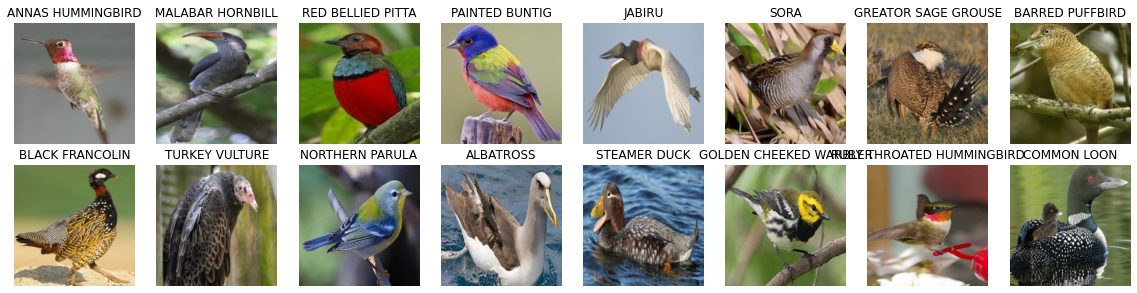

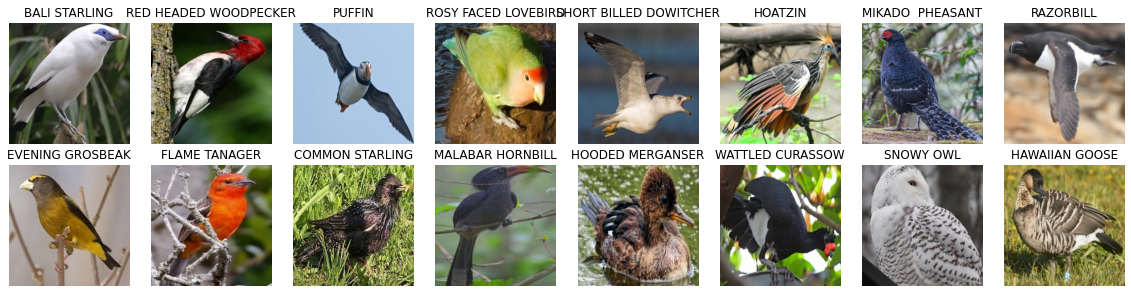

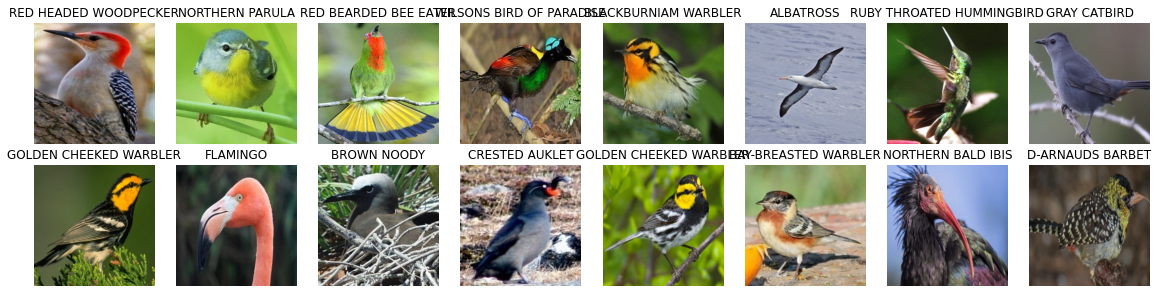

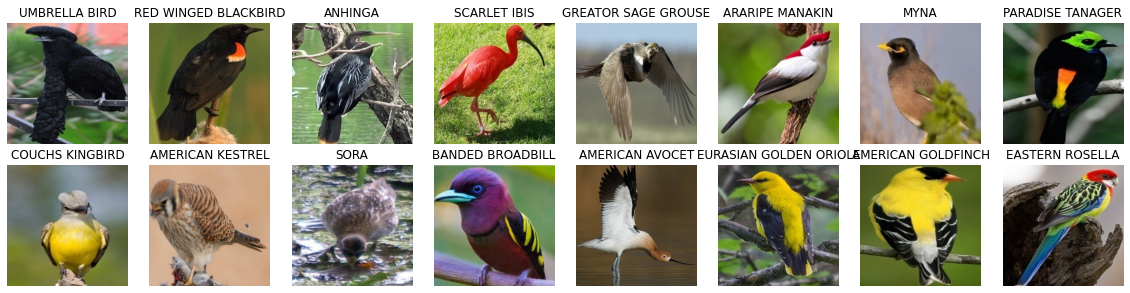

In [10]:
for i in range(4):
  x, y = train_generator.next()
  show_grid(x, 2, 8, label_list = y, show_labels = True, figsize = (20,10), savename = '/content/drive/MyDrive/CN/image_grid.png')


A função ``analyze_dataset`` constroí um gráfico que analiza o número de imagens de cada classe do *dataset* passado como parâmetro.

In [12]:
def analyze_dataset(train_gen):
  #count the number of images of each class
  unique, counts = np.unique(train_gen.classes, return_counts=True)
  d = dict(zip(unique, counts))
  #print(d)
  print("Classe with less images: ", min(d.items(), key=lambda x: x[1] ))
  print("Classe with more images: ", max(d.items(), key=lambda x: x[1] ))
  print("Mean of images: ", mean(d[k] for k in d))

  #presenting the number of images of each class in a plot
  plt.figure(figsize=(20, 5))
  plt.bar(d.keys(), d.values(), width = 1.2, color = ['paleturquoise', 'yellow', 'orange'])
  plt.xlabel('Classes')
  plt.ylabel('Number of images per class')
  plt.show()

Classe with less images:  (194, 95)
Classe with more images:  (210, 300)
Mean of images:  140


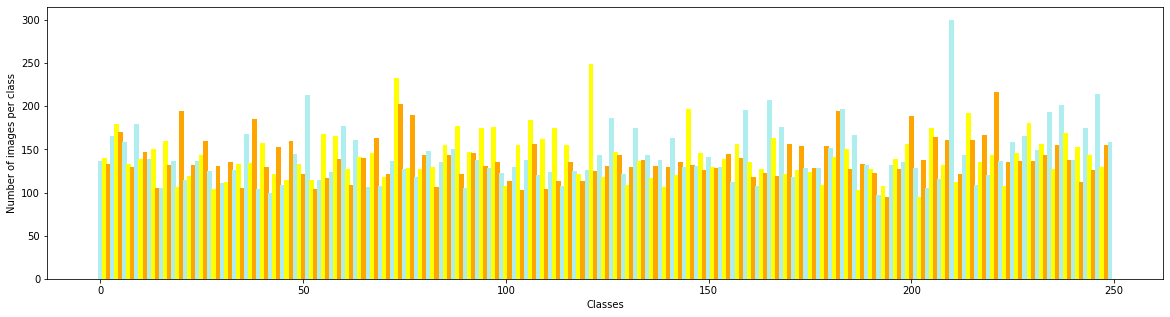

In [13]:
analyze_dataset(train_generator)

## *Image Augmentation*

In [14]:
train_datagen_aug = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

train_generator_aug, _, _ = generate_datasets(16, train_datagen_aug)


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


## Definição do modelo CNN para múltiplas classes

Este modelo consiste numa primeira abordagem ao problema.

In [15]:
import datetime

start = datetime.datetime.now()
def CNN_model(n_layers, bs, op, ep):
    model = tf.keras.models.Sequential([

      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(momentum=0.9),
      tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten()])
      
    #dense layers
    for i in range(n_layers):
      model.add(Dense(512, activation='relu'))
    
    #tf.keras.layers.Dropout(0.2),

    model.add(Dense(250, activation='softmax'))
    
    model.summary()

    #compile
    model.compile(loss='categorical_crossentropy',
              optimizer= op,
              metrics=['acc'])

    #fit
    history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs= ep,
      verbose=1,
      validation_data = validation_generator,
      validation_steps = 8)
    model.save('model.h5')

    return model, history

#CNN_model(2, 32, "adam", 50)

Vamos agora treinar o modelo.

In [ ]:
CNN_model(op, ep)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
8/8 [==============================] - 48s 6s/step - loss: 5.6886 - acc: 0.0000e+00 - val_loss: 5.5979 - val_acc: 0.0000e+00
Epoch 2/15
8/8 [==============================] - 47s 6s/step - loss: 5.5683 - acc: 0.0189 - val_loss: 5.5820 - val_acc: 0.0000e+00
Epoch 3/15
8/8 [==============================] - 42s 5s/step - loss: 5.5210 - acc: 0.0070 - val_loss: 5.4902 - val_acc: 0.0000e+00
Epoch 4/15
8/8 [==============================] - 44s 6s/step - loss: 5.6018 - acc: 0.0078 - val_loss: 5.5985 - val_acc: 0.0000e+00
Epoch 5/15
8/8 [==============================] - 43s 6s/step - loss: 5.5320 - acc: 0.0000e+00 - val_loss: 5.4842 - val_acc: 0.0000e+00
Epoch 6/15
8/8 [==============================] - 43s 6s/step - loss: 5.5402 - acc: 0.0191 - val_loss: 5.7752 - val_acc: 0.0000e+00
Epoch 7/15
8/8 [==============================] - 43s 5s/step - loss: 5.5294 - acc: 0.0102 - val_loss: 7.5166 - val_acc: 0.0000e+00
Epoch 8/15
8/8 [==============================] - 41s 5s/step - loss

A função ``plot_metrics``, a seguir definida, trata de criar os gráficos referentes aos valores das métricas a analisar.

In [ ]:
def plot_metrics(history):  
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Algoritmo Genético
No sentido de automatizar o processo de otimização dos hiperparâmetros de um modelo de uma CNN, seja ele desenvolvido de raíz ou recorrendo a *transfer learning*, foi definido um algoritmo genético.

Cada cromossoma terá em conta os hiperparâmetros que se pretende avaliar na rede. Nomeadamente, a taxa de aprendizagem, a função de otimização utilizada e o valor de *learning rate*.

Para seleção do melhor modelo, vamos apenar utilizar 5 *epochs* por cada um. 



In [ ]:
#list of the possible values for each chromosome
lr_values = [0.1, 0.01, 0.001, 0.0001]
op_values = ["adamax", "adadelta", "adam", "adagrad", "sgd"]
bs_values = [8, 16, 32]
activ_values = ['elu', 'relu', 'tanh']

'''
Function that defines a chromosome
'''
def create_individual():  
  parameters = {}

  lr = choice(lr_values)
  parameters["lr"] = lr
  
  bs = choice(bs_values)
  parameters["bs"] = bs

  activ = choice(activ_values)
  parameters["activ"] = activ
  
  op = choice(op_values)
  parameters["op"] = op
  
  #ep = randint(50, 100)
  #parameters["ep"] = ep
  
  return parameters


'''
Function responsible for generating the population
'''
def generate_population(n):
  population = []

  for i in range(n):
    chromosome = create_individual()
    population.append(chromosome)
  return population


'''
Fitness function based on accuracy and loss
''' 
def fitness_evaluation(history):
  acc = max(history.history['accuracy'])
  loss = max(history.history['loss'])
  print("ACC ", acc)
  print("LOSS ", loss)
  return 0.8 * acc - 0.2 * loss


'''
Selection function based on the roulette wheel method (from: https://github.com/KrishnaManmayi/Hyper-Parameter-Optimization-of-CNN-using-genetic-algorithm/blob/main/Optimization_using_genetic_algorithm_Cifar10_using_CNN.ipynb)
'''
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

'''
Function responsible for crossover. Random select gene from one of the two parents
'''
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["lr"] = choice([parent1["lr"], parent2["lr"]])
  child2["lr"] = choice([parent1["lr"], parent2["lr"]])

  child1["bs"] = choice([parent1["bs"], parent2["bs"]])
  child2["bs"] = choice([parent1["bs"], parent2["bs"]])

  child1["op"] = parent2["op"]
  child2["op"] = parent1["op"]

  child1["activ"] = parent1["activ"]
  child2["activ"] = parent2["activ"]
  return [child1, child2]


'''
Function responsible for mutation that swaps a random gene of a chromosome
'''
def mutation(chromosome):
  #select random gene to mutate
  m = randint(0,4)
  if m == 0:
    chromosome["lr"] = choice([x for x in lr_values if x != chromosome['lr']])

  elif m == 1:
    chromosome["op"] = choice([x for x in op_values if x != chromosome['op']])

  elif m == 2:
    chromosome["activ"] = choice([x for x in activ_values if x != chromosome['activ']])
  
  elif m == 3:
    chromosome["bs"] = choice([x for x in bs_values if x != chromosome['bs']])
  
  return chromosome

In [ ]:
model, history = ResNet101V2_model(8, 'elu', 'adam', 0.001, 1)
acc = fitness_evaluation(history)

In [ ]:
print(history.history)
acc = fitness_evaluation(history)
plot_metrics(history)

In [ ]:
model, history = ResNet101V2_model(bs, activ, op, lr, 5)
acc = fitness_evaluation(history)

In [ ]:

generations = 5
threshold = 0.5
num_pop = 10

pops_fitness = {}
for i in range(generations):
  pops_fitness[i] = []

population = generate_population(num_pop)

for generation in range(generations):

  population_fitness = []
  for chromosome in population:
    lr = chromosome["lr"]
    bs = chromosome["bs"]
    op = chromosome["op"]
    activ = chromosome["activ"]

    try:
      model, history = ResNet101V2_model(bs, activ, op, lr, 5)
      print("HISTORY ", history.history)
      acc = fitness_evaluation(history)
      print("Parameters: ", chromosome)
      print("Accuracy: ", round(acc,3))
    except:
      acc=0.0000001
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")

    population_fitness.append(acc)
  
  print("POP FITNESS ", population_fitness)
  pops_fitness[generation] = population_fitness
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]]
  parent2 = population[parents_ind[1]]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append(child1)
  population.append(child2)

  print("Generation ", generation+1," Outcome: ")
  if max(population_fitness) >= threshold:
    print("Obtained desired accuracy: ", max(population_fitness))
    break
  else:
    print("Maximum accuracy in generation {} : {}".format(generation + 1, max(population_fitness)))

  first_min = min(population_fitness)
  first_min_ind = population_fitness.index(first_min)
  population.remove(population[first_min_ind])
  second_min = min(population_fitness)
  second_min_ind = population_fitness.index(second_min)
  population.remove(population[second_min_ind])

Found 35222 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
171319296/171317808 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
______________________________________________________

## Definição do modelo VGG16

In [ ]:
import datetime
start = datetime.datetime.now()
num_classes = 250

def VGG16_model(op):
  # loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
  vgg = tf.keras.applications.VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

  # this will exclude the initial layers from training phase as there are already been trained.
  for layer in vgg.layers:
      layer.trainable = False

  x = Flatten()(vgg.output)
  #x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
  x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

  model = Model(inputs = vgg.input, outputs = x)

  model.compile(loss='categorical_crossentropy', optimizer= op, metrics=['accuracy'])
  end= datetime.datetime.now()
  elapsed= end-start
  print ('Time: ', elapsed)

In [ ]:
model.summary()

## Definição do modelo ResNet50

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
from keras.applications import resnet50

def ResNet50_model(op, ep):

  es = EarlyStopping(monitor='val_loss', patience=5)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  start = datetime.now()
  conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
  for layer in conv_model.layers:
      layer.trainable = False
  x = keras.layers.Flatten()(conv_model.output)
  x = keras.layers.Dense(100, activation='relu')(x)
  x = keras.layers.Dense(100, activation='relu')(x)
  x = keras.layers.Dense(100, activation='relu')(x)
  predictions = keras.layers.Dense(250, activation='softmax')(x)
  full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
  full_model.summary()

  full_model.compile(loss='categorical_crossentropy',
                  optimizer= op,
                  metrics=['acc'])
  
  history = full_model.fit_generator(
    train_generator, 
    callbacks = [es, mc],
    validation_data = validation_generator,
    workers=10,
    epochs = ep,
  )

  
  end= datetime.now()
  elapsed= end-start
  print ('Time: ', elapsed)

  return full_model, history

In [ ]:
model, history = ResNet50_model("adam", 30)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1101/1101 [==============================] - 137s 122ms/step - loss: 5.5507 - acc: 0.0068 - val_loss: 5.5336 - val_acc: 0.0040
Epoch 2/30
1101/1101 [==============================] - 134s 121ms/step - loss: 5.5064 - acc: 0.0081 - val_loss: 5.5375 - val_acc: 0.0040
Epoch 3/30
1101/1101 [==============================] - 133s 121ms/step - loss: 5.5060 - acc: 0.0082 - val_loss: 5.5366 - val_acc: 0.0040
Epoch 4/30
1101/1101 [==============================] - 133s 120ms/step - loss: 5.5039 - acc: 0.0083 - val_loss: 5.5345 - val_acc: 0.0040
Epoch 5/30
1101/1101 [==============================] - 132s 119ms/step - loss: 5.5028 - acc: 0.0091 - val_loss: 5.5371 - val_acc: 0.0040
Epoch 6/30
1101/1101 [==============================] - 132s 119ms/step - loss: 5.5034 - acc: 0.0094 - val_loss: 5.5364 - val_acc: 0.0040
Time:  0:13:23.672970


In [ ]:
for layers in (model.layers)[:19]:
    print(layers)
    layers.trainable = False

In [ ]:
X= model.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(model.input, predictions)

In [ ]:
model_final.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_final.summary()

## ResNet101V2

In [ ]:
from keras.applications import ResNet101V2

def ResNet101V2_model(bs, activ, op, lr_value, ep):

  train_gen, validation_gen, test_gen = generate_datasets(bs, train_datagen)

  es = EarlyStopping(monitor='val_loss', patience = 5)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
  for layer in convlayer.layers:
      layer.trainable=False

  model = tf.keras.models.Sequential()
  model.add(convlayer)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(2048, kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation(activ))
  model.add(Dropout(0.5))
  model.add(Dense(1024, kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation(activ))
  model.add(Dropout(0.5))
  model.add(Dense(250,activation = 'softmax'))
  print(model.summary())

  if op == "adam":
    opt = tf.keras.optimizers.Adam(lr = lr_value)

  elif op == 'sgd':
    opt = tf.keras.optimizers.SGD(lr = lr_value)

  elif op == 'adagrad':
    opt = tf.keras.optimizers.Adagrad(lr = lr_value)
    
  elif op == 'adadelta':
    opt = tf.keras.optimizers.Adadelta(lr = lr_value)

  elif op == 'rmsprop':
    opt = tf.keras.optimizers.RMSprop(lr = lr_value)

  model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

  history = model.fit(train_gen, callbacks = [es, mc], validation_data = validation_gen,
         epochs = ep)
  
  return model, history

In [ ]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [ ]:
history=model.fit(train_generator, validation_data = validation_generator,
         epochs = 5)

Epoch 1/5
1101/1101 [==============================] - 7097s 6s/step - loss: 2.9789 - accuracy: 0.3910 - val_loss: 0.4042 - val_accuracy: 0.8888
Epoch 2/5
1101/1101 [==============================] - 233s 211ms/step - loss: 0.5286 - accuracy: 0.8493 - val_loss: 0.2669 - val_accuracy: 0.9216
Epoch 3/5
1101/1101 [==============================] - 233s 211ms/step - loss: 0.2937 - accuracy: 0.9126 - val_loss: 0.2716 - val_accuracy: 0.9184
Epoch 4/5
1101/1101 [==============================] - 232s 211ms/step - loss: 0.2205 - accuracy: 0.9298 - val_loss: 0.3406 - val_accuracy: 0.9224
Epoch 5/5
1101/1101 [==============================] - 232s 211ms/step - loss: 0.1856 - accuracy: 0.9410 - val_loss: 0.3099 - val_accuracy: 0.9240


In [ ]:
opt=tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
history_1=model.fit(train_generator,validation_data=validation_generator,
         epochs=1)

134/134 [==============================] - 6745s 50s/step - loss: nan - accuracy: 0.0037 - val_loss: nan - val_accuracy: 0.0042


In [ ]:
model, history = ResNet101V2_model(8, 'tanh', 'adagrad', 0.01, 100)
acc = fitness_evaluation(history)
model.save("/content/drive/My Drive/CN/best_model.h5")

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
171319296/171317808 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
______________________________________________________

In [ ]:
acc = fitness_evaluation(history)
model.save("/content/drive/My Drive/CN/best_model.h5")

##  Avaliar a *performance* do modelo

Vamos agora avaliar a performance do modelo final selecionado, com o *dataset* de teste.


In [ ]:
lr = 0.1
bs =  16
activ = 'tanh'
op = 'adadelta'
ep = 10

model, history = ResNet101V2_model(bs, activ, op, lr, ep)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
171319296/171317808 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
______________________________________________________

ACC  0.9998295903205872
LOSS  2.432058095932007


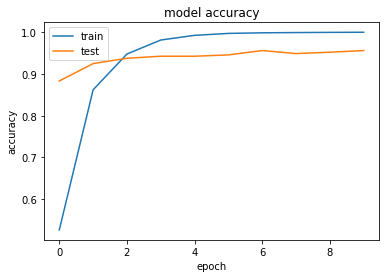

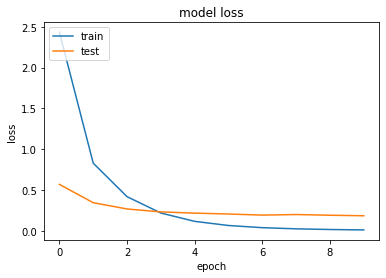

In [ ]:
fit = fitness_evaluation(history)
plot_metrics(history)
model.save('/content/drive/My Drive/CN/best_model.h5')

In [ ]:
final_model = load_model('/content/drive/My Drive/CN/best_model.h5')


In [ ]:
results = final_model.evaluate(test_generator)

79/79 [==============================] - 9s 88ms/step - loss: 0.1235 - accuracy: 0.9696


In [ ]:
#print(results)
print(test_generator.classes)

[  0   0   0 ... 249 249 249]


## Previsões das classes de imagens

Vamos agora tentar fazer algumas previsões das imagens do *dataset* de teste e, de seguida, analisar os dados relativamente a essas previsões.

In [ ]:
predictions = final_model.predict(test_generator, batch_size = 16)


In [ ]:
predicted_classes = np.argmax(predictions, axis = 1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [ ]:
print(true_classes)
print(predicted_classes)

[  0   0   0 ... 249 249 249]
[100 230 125 ...  59 146 202]


In [ ]:
y_pred_gen = np.array([np.argmax(x) for x in predicted_classes])

In [ ]:
y_pred_gen = y_pred_gen[:,np.newaxis]

In [ ]:
x_train = train_generator.classes
y_train = test_generator.labels

In [ ]:
Y_train_argmax = np.array([np.argmax(x) for x in y_train]).reshape(-1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_gen = confusion_matrix(true_classes, predicted_classes)

In [ ]:
print(cm_gen)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Heat Map for Genetic CNN Architecture')

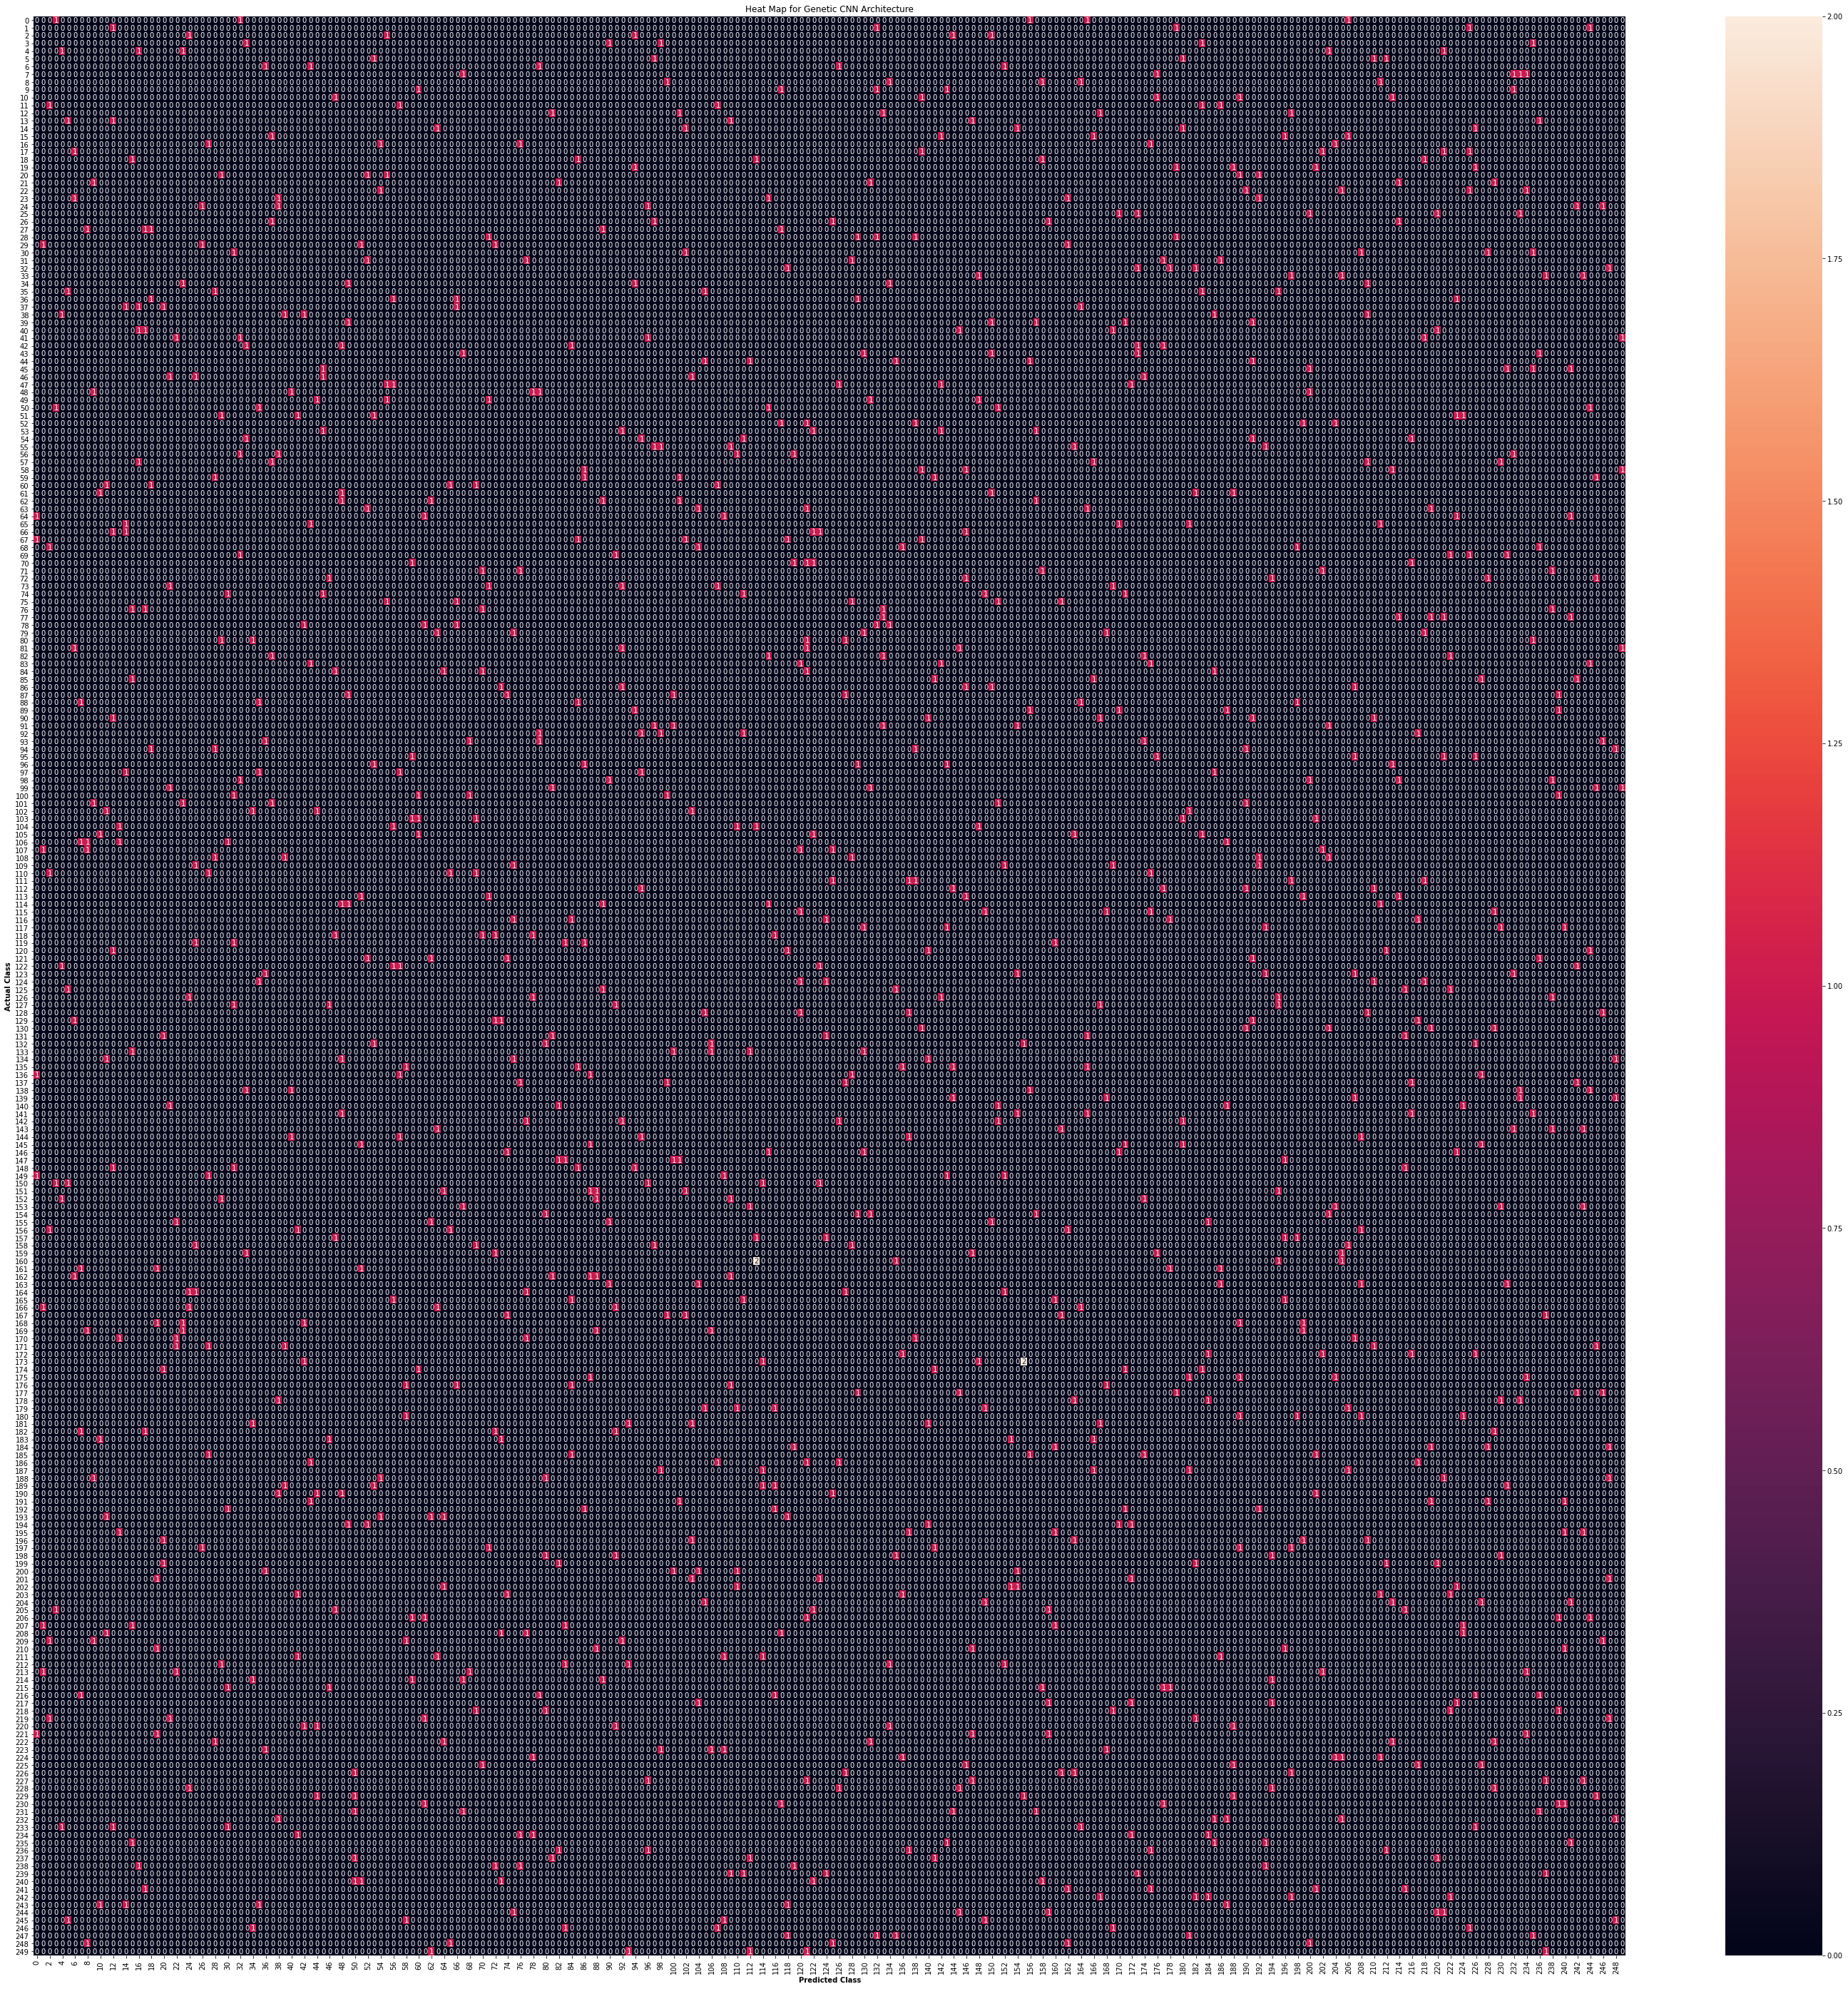

In [ ]:
plt.figure(figsize = (50, 50))
sns.heatmap(cm_gen, annot = True)
plt.xlabel('Predicted Class',fontweight = 'bold')
plt.ylabel('Actual Class',fontweight = 'bold')
plt.title('Heat Map for Genetic CNN Architecture')

In [ ]:
print(history)

In [ ]:
class_pred_acc = []
for i in range(250):
    class_pred_acc.append(int((cm_gen[i][i]/10) * 100))
    

Text(0.5, 1.0, 'Percentage Classification Accuracy - Genetic CNN')

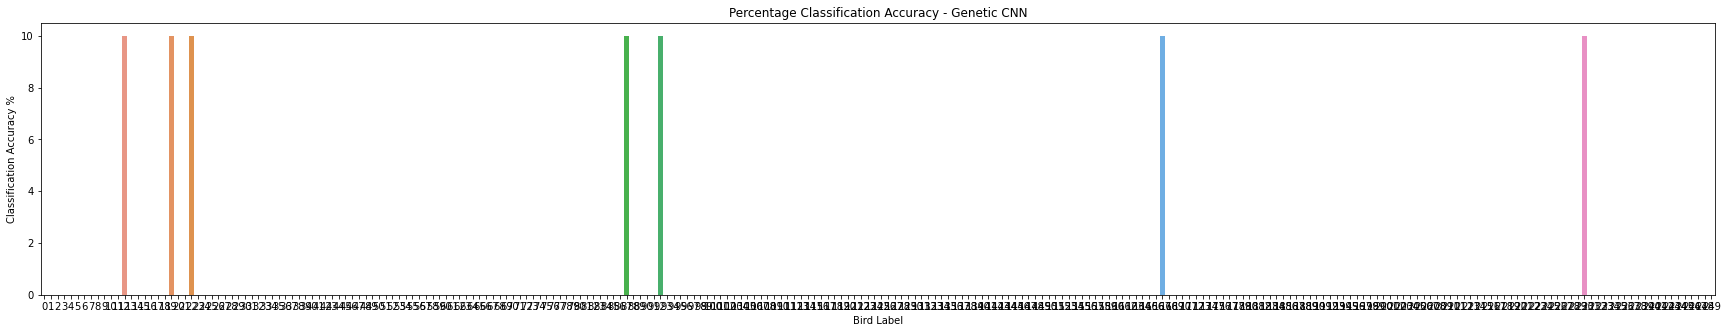

In [ ]:
plt.figure(figsize=(30, 5))
sns.barplot(x= list(range(250)), y = class_pred_acc)
plt.ylabel('Classification Accuracy %')
plt.xlabel('Bird Label')
plt.title('Percentage Classification Accuracy - Genetic CNN')

In [ ]:
model.evaluate(test_generator, use_multiprocessing = True, workers = 10)


Referências Bibliográficas

* https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

* https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

* Loss_Scarce_Categorical: https://stackoverflow.com/questions/63600431/model-fit-typeerror-nonetype-object-is-not-callable

* https://www.kaggle.com/pankul/image-classification-w-vgg16-weights

* https://medium.com/analytics-vidhya/multi-class-classification-using-cnn-for-custom-dataset-7759865bd19

### Algoritmo Genético
* https://blog.coast.ai/lets-evolve-a-neural-network-with-a-genetic-algorithm-code-included-8809bece164

* https://yaron-strauch.com/Evolving%20Convolutional%20Neural%20Network%20Topologies%20for%20Image%20Recognition%20-%20Yaron%20Strauch.pdf

* https://blog.paperspace.com/train-keras-models-using-genetic-algorithm-with-pygad/